In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from datetime import datetime
import random
import os
import time
import pandas as pd

In [2]:
# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
# CutMix function
# Used from the link given in the paper: https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py
def cutmix(inputs, labels, alpha=1.0):
    """Applies CutMix augmentation."""
    lam = np.random.beta(alpha, alpha)
    batch_size = inputs.size(0)
    rand_index = torch.randperm(batch_size).to(inputs.device)
    shuffled_labels = labels[rand_index]
    
    bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
    inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
    
    return inputs, labels, shuffled_labels, lam

In [4]:
def rand_bbox(size, lam):
    """Generate a random bounding box for CutMix."""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [5]:
# Train function
def train_nn(model, train_loader, criterion, optimizer, device, cutmix_prob=0.5, cutmix_alpha=1.0):
    """Function to train the neural network for one epoch with optional CutMix."""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        if np.random.rand() < cutmix_prob:
            inputs, labels_a, labels_b, lam = cutmix(inputs, labels, alpha=cutmix_alpha)
            outputs = model(inputs)
            loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_labels = torch.argmax(outputs, dim=1)
        total_labels += labels.size(0)
        correct_labels += torch.sum(predicted_labels == labels).item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_labels / total_labels
    
    return train_loss, train_accuracy

In [6]:
# Evaluation function
def evaluate_nn(model, test_loader, criterion, device):
    """Function to evaluate the neural network on the test data."""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted_labels = torch.argmax(outputs, dim=1)
            total_labels += labels.size(0)
            correct_labels += torch.sum(predicted_labels == labels).item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct_labels / total_labels
    return test_loss, test_accuracy

In [7]:
def prepare_model(model_name, num_classes):
    """
    Prepare a model for training, either as a feature extractor or for fine-tuning.
    """
    # Load the pre-trained model
    if model_name == "resnet":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    elif model_name == "squeezenet":
        model = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.DEFAULT)
    elif model_name == "convnext":
        model = models.convnext_base(weights=models.ConvNeXt_Base_Weights.IMAGENET1K_V1)
    elif model_name == "vit":
        model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
    elif model_name == "mobilenet":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")
    
    # Modify the last layer for the dataset
    if model_name == "squeezenet":
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
    elif model_name == "convnext":
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    elif model_name == "vit":
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    elif model_name == "mobilenet":
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:  # ResNet
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    # # If using as a fixed feature extractor, freeze all layers except the final layer
    # if feature_extractor:
    #     for param in model.parameters():
    #         param.requires_grad = False
        
    #     # Enable gradients only for the last layer
    #     if model_name == "squeezenet":
    #         for param in model.classifier[1].parameters():
    #             param.requires_grad = True
    #     elif model_name == "convnext":
    #         for param in model.classifier[2].parameters():
    #             param.requires_grad = True
    #     elif model_name == "vit":
    #         for param in model.heads.head.parameters():
    #             param.requires_grad = True
    #     else:  # ResNet
    #         for param in model.fc.parameters():
    #             param.requires_grad = True

    return model

In [8]:
def run_training(
    model_name,
    model,
    train_loader,
    test_loader,
    lr,
    num_epochs,
    num_classes,
    cutmix_alpha=1.0,
    cutmix_prob=0.5,
    weight_decay=1e-4,
    log_dir="runs",
    save_path="saved_models"
):
    """
    Run training for a model.

    Args:
        model_name (str): Name of the model.
        model: An instance of the model.
        train_loader: DataLoader for training data.
        test_loader: DataLoader for testing data.
        lr (float): Learning rate.
        num_epochs (int): Number of epochs.
        num_classes (int): Number of classes in the dataset.
        alpha (float): Mixup parameter.
        cutmix_prob (float): Probability of applying CutMix.
        weight_decay (float): Weight decay for optimizer.
        log_dir (str): Directory for TensorBoard logs.
        save_path (str): Directory to save the trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    # Define optimizer and learning rate scheduler
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Loss function
    criterion = nn.CrossEntropyLoss()


    # Training loop
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    learning_rates = []

    # TensorBoard setup
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in tqdm(range(num_epochs)):
        # Training
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device, cutmix_alpha, cutmix_prob)
        # Evaluation
        test_loss, test_accuracy = evaluate_nn(model, test_loader, criterion, device)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Update scheduler
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Logging to TensorBoard
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Test", test_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_accuracy, epoch)
        writer.add_scalar("Accuracy/Test", test_accuracy, epoch)
        writer.add_scalar("Learning_Rate", current_lr, epoch)

        # Logging to console
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")



    # Save the model
    os.makedirs(save_path, exist_ok=True)
    model_save_path = os.path.join(save_path, f"{model_name}_final.pth")
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Close TensorBoard writer
    writer.close()

    return model, train_losses, train_accuracies, test_losses, test_accuracies, learning_rates

In [18]:
def combine_training(
    model_name,
    train_loader,
    test_loader,
    lr,
    fixed_num_epochs,
    full_num_epochs,
    num_classes,
    freeze_feature_extractor=False,
    full_finetune=False,
    weight_decay=1e-4,
    cutmix_alpha=1.0,
    cutmix_prob=0.5,
    log_dir="runs",
    save_path="saved_models"
):
    """
    Combined training function for using the model as a fixed feature extractor
    and/or fully fine-tuning the model.

    Args:
        model_name (str): Name of the model.
        train_loader: DataLoader for training data.
        test_loader: DataLoader for testing data.
        lr (float): Learning rate.
        num_epochs (int): Number of epochs.
        num_classes (int): Number of classes in the dataset.(now redundant)
        freeze_feature_extractor (bool): Whether to freeze feature extractor layers.
        full_finetune (bool): Whether to fine-tune the entire model.
        weight_decay (float): Weight decay for optimizer.
        cutmix_alpha (float): Mixup parameter.
        cutmix_prob (float): Probability of applying CutMix.
        log_dir (str): Directory for TensorBoard logs.
        save_path (str): Directory to save the trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Number of classes
    num_classes = len(train_loader.dataset.classes)

    # Prepare the model
    model = prepare_model(model_name, num_classes)

    combined_train_losses = []
    combined_train_accuracies = []
    combined_test_losses = []
    combined_test_accuracies = []

    # If freeze_feature_extractor is enabled
    if freeze_feature_extractor:
        print(f"Using {model_name} as a fixed feature extractor.")
        for param in model.parameters():
            param.requires_grad = False
    
        # Check if all parameters are frozen
        all_frozen = all(not param.requires_grad for param in model.parameters())
        print(f"Are all weights frozen? {all_frozen}")

        # # Unfreeze the classifier layer
        # for param in model.fc.parameters():
        #     param.requires_grad = True

        # num_logits = model.fc.in_features
        # model.fc = nn.Linear(num_logits, num_classes)

        # Update the classification head based on model architecture
        if hasattr(model, "fc"):  # Models with fully connected layers (e.g., ResNet)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif hasattr(model, "classifier"):  # Models like AlexNet, ConvNeXt, MobileNet, SqueezeNet
            if model_name == "mobilenet":  # MobileNet specific adjustment
                model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
            elif model_name == "squeezenet":  # SqueezeNet specific adjustment
                model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
            else:  # Generic case for other classifier-based models
                model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
        elif hasattr(model, "heads"):  # Vision Transformer (ViT)
            model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
        else:
            raise ValueError(f"Unsupported model architecture for {model_name}")


        print("Training with fixed feature extractor...")
        start_time = time.time()
        model, train_losses, train_accuracies, test_losses, test_accuracies, learning_rates = run_training(
            model_name=model_name,
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            lr=lr,
            num_epochs=fixed_num_epochs,
            num_classes=num_classes,
            cutmix_alpha=cutmix_alpha,
            cutmix_prob=cutmix_prob,
            weight_decay=weight_decay,
            log_dir=f"{log_dir}/fixed_feature_extractor",
            save_path=f"{save_path}/fixed_feature_extractor",
        )
        elapsed_time = time.time() - start_time
        # writer.add_scalar("Training Time/Fixed Feature Extractor", elapsed_time)
        print(f"Fixed feature extractor training completed in {elapsed_time:.2f} seconds.")
        
        combined_train_losses.extend(train_losses)
        combined_test_losses.extend(test_losses)
        combined_train_accuracies.extend(train_accuracies)
        combined_test_accuracies.extend(test_accuracies)

    # If full_finetune is enabled
    if full_finetune:
        print(f"Fine-tuning the entire {model_name} model.")
        for param in model.parameters():
            param.requires_grad = True

        # Verify if all parameters are set to requires_grad = True
        all_trainable = all(param.requires_grad for param in model.parameters())
        print(f"All parameters set to requires_grad=True: {all_trainable}")

        print("Training with full fine-tuning...")
        start_time = time.time()
        model, train_losses, train_accuracies, test_losses, test_accuracies, learning_rates = run_training(
            model_name=model_name,
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            lr=lr * 0.5,                            # Lowering the learning rate
            num_epochs=full_num_epochs,
            num_classes=num_classes,
            cutmix_alpha=cutmix_alpha,
            cutmix_prob=cutmix_prob,
            weight_decay=weight_decay,
            log_dir=f"{log_dir}/full_finetune",
            save_path=f"{save_path}/full_finetune",
        )
        elapsed_time = time.time() - start_time
        # writer.add_scalar("Training Time/Full Fine-Tuning", elapsed_time)
        print(f"Full fine-tuning completed in {elapsed_time:.2f} seconds.")

        combined_train_losses.extend(train_losses)
        combined_test_losses.extend(test_losses)
        combined_train_accuracies.extend(train_accuracies)
        combined_test_accuracies.extend(test_accuracies)
    
    return model, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies

    # Close TensorBoard writer
    # writer.close()

In [19]:
data_dir = '/home/ahmad/courses/cuda_lab/MA-INF-4308-Lab-Vision-Systems/Assignment-3/dataset'

In [20]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Set random seed
set_seed()

In [21]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
    ], p=0.8),
    # AutoAugment(AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [22]:
# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), val_transforms)

In [23]:
train_dataset.classes, val_dataset.classes

(['person', 'robot'], ['person', 'robot'])

In [24]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [25]:
model, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies = combine_training(
    model_name="convnext",
    train_loader=train_loader,
    test_loader=val_loader,
    lr=0.001,
    fixed_num_epochs=5,
    full_num_epochs=20,
    num_classes=2,
    freeze_feature_extractor=True,
    full_finetune=True,
    log_dir="logs",
    save_path="models"
)

Using convnext as a fixed feature extractor.
Are all weights frozen? True
Training with fixed feature extractor...


 20%|█████████████████████████████▊                                                                                                                       | 1/5 [01:19<05:17, 79.43s/it]

Epoch 1/5
Train Loss: 0.5121, Train Accuracy: 0.8294
Test Loss: 0.2149, Test Accuracy: 0.9833
Learning Rate: 0.001000


 40%|███████████████████████████████████████████████████████████▌                                                                                         | 2/5 [02:53<04:24, 88.21s/it]

Epoch 2/5
Train Loss: 0.4086, Train Accuracy: 0.8118
Test Loss: 0.1105, Test Accuracy: 1.0000
Learning Rate: 0.000905


 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 3/5 [04:39<03:12, 96.29s/it]

Epoch 3/5
Train Loss: 0.3641, Train Accuracy: 0.8794
Test Loss: 0.0834, Test Accuracy: 1.0000
Learning Rate: 0.000655


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4/5 [06:24<01:39, 99.60s/it]

Epoch 4/5
Train Loss: 0.3997, Train Accuracy: 0.8441
Test Loss: 0.0782, Test Accuracy: 1.0000
Learning Rate: 0.000345


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:19<00:00, 99.98s/it]

Epoch 5/5
Train Loss: 0.4169, Train Accuracy: 0.7529
Test Loss: 0.0775, Test Accuracy: 1.0000
Learning Rate: 0.000095


Model saved to models/fixed_feature_extractor/convnext_final.pth
Fixed feature extractor training completed in 500.27 seconds.
Fine-tuning the entire convnext model.
All parameters set to requires_grad=True: True
Training with full fine-tuning...


  5%|███████▎                                                                                                                                         | 1/20 [04:10<1:19:14, 250.22s/it]

Epoch 1/20
Train Loss: 0.5215, Train Accuracy: 0.7529
Test Loss: 0.0780, Test Accuracy: 1.0000
Learning Rate: 0.000500


 10%|██████████████▌                                                                                                                                  | 2/20 [08:16<1:14:22, 247.89s/it]

Epoch 2/20
Train Loss: 0.3710, Train Accuracy: 0.8912
Test Loss: 0.0640, Test Accuracy: 1.0000
Learning Rate: 0.000497


 15%|█████████████████████▊                                                                                                                           | 3/20 [12:16<1:09:13, 244.35s/it]

Epoch 3/20
Train Loss: 0.3512, Train Accuracy: 0.8588
Test Loss: 0.0377, Test Accuracy: 1.0000
Learning Rate: 0.000488


 20%|█████████████████████████████                                                                                                                    | 4/20 [16:16<1:04:44, 242.77s/it]

Epoch 4/20
Train Loss: 0.3858, Train Accuracy: 0.8235
Test Loss: 0.0392, Test Accuracy: 1.0000
Learning Rate: 0.000473


 25%|████████████████████████████████████▎                                                                                                            | 5/20 [20:19<1:00:40, 242.69s/it]

Epoch 5/20
Train Loss: 0.2955, Train Accuracy: 0.9147
Test Loss: 0.0273, Test Accuracy: 1.0000
Learning Rate: 0.000452


 30%|████████████████████████████████████████████                                                                                                       | 6/20 [24:04<55:11, 236.53s/it]

Epoch 6/20
Train Loss: 0.2969, Train Accuracy: 0.8647
Test Loss: 0.0195, Test Accuracy: 1.0000
Learning Rate: 0.000427


 35%|███████████████████████████████████████████████████▍                                                                                               | 7/20 [27:50<50:32, 233.24s/it]

Epoch 7/20
Train Loss: 0.2699, Train Accuracy: 0.9235
Test Loss: 0.0298, Test Accuracy: 1.0000
Learning Rate: 0.000397


 40%|██████████████████████████████████████████████████████████▊                                                                                        | 8/20 [31:30<45:47, 228.97s/it]

Epoch 8/20
Train Loss: 0.3390, Train Accuracy: 0.8559
Test Loss: 0.0340, Test Accuracy: 1.0000
Learning Rate: 0.000363


 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 9/20 [35:20<42:02, 229.32s/it]

Epoch 9/20
Train Loss: 0.2611, Train Accuracy: 0.9559
Test Loss: 0.0149, Test Accuracy: 1.0000
Learning Rate: 0.000327


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 10/20 [39:15<38:29, 231.00s/it]

Epoch 10/20
Train Loss: 0.3930, Train Accuracy: 0.7971
Test Loss: 0.0263, Test Accuracy: 1.0000
Learning Rate: 0.000289


 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                 | 11/20 [43:04<34:35, 230.62s/it]

Epoch 11/20
Train Loss: 0.2564, Train Accuracy: 0.9206
Test Loss: 0.0169, Test Accuracy: 1.0000
Learning Rate: 0.000250


 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                 | 11/20 [46:40<38:11, 254.63s/it]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(combined_train_losses, label='Train Loss', marker='o', markeredgecolor='black')
plt.plot(combined_test_losses, label='Test Loss', marker='o', markeredgecolor='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model metrics - Loss')

plt.subplot(1, 2, 2)
plt.plot(combined_train_accuracies, label='Train Accuracy', marker='o', markeredgecolor='black')
plt.plot(combined_test_accuracies, label='Test Accuracy', marker='o', markeredgecolor='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model metrics - Accuracy')
plt.tight_layout()

# plt.subplot(1, 3, 3)
# plt.plot(learning_rates, label='Learning Rate', marker='o', markeredgecolor='black', color='blue')
# # plt.plot(test_accuracies, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# plt.legend()
# plt.title('Model metrics - LR')
# plt.tight_layout()

plt.show()

In [34]:
# Get predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_pred, y_true = get_predictions(model, val_loader, device)

In [44]:
def load_model(model_name, weights_path, num_classes=2, device=None):
    """
    Load a pre-trained model with modified classification layers and custom weights.
    
    Args:
        model_name (str): The name of the model ('resnet', 'squeezenet', 'convnext', 'vit', 'mobilenetv2').
        weights_path (str): Path to the trained weights file.
        num_classes (int): Number of output classes (default is 2).
        device (torch.device, optional): Device to load the model onto. Defaults to auto-detect.

    Returns:
        model: The loaded and modified model.
    """
    # Default to auto-detecting the device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize the model
    if model_name == "resnet":
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "squeezenet":
        model = models.squeezenet1_1(pretrained=False)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
    elif model_name == "convnext":
        model = models.convnext_base(pretrained=False)
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    elif model_name == "vit":
        model = models.vit_b_16(pretrained=False)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    elif model_name == "mobilenetv2":
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    # Load the state dictionary
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)

    # Move the model to the device
    model.to(device)

    # Set the model to evaluation mode for inference
    model.eval()

    print(f"{model_name.capitalize()} model loaded successfully.")
    return model

In [46]:
resnet_weights_path = "/home/ahmad/courses/cuda_lab/MA-INF-4308-Lab-Vision-Systems/Assignment-3/models/full_finetune/resnet_final.pth"
squeezenet_weights_path = "/home/ahmad/courses/cuda_lab/MA-INF-4308-Lab-Vision-Systems/Assignment-3/models/full_finetune/squeezenet_final.pth"
mobilenet_weights_path = "/home/ahmad/courses/cuda_lab/MA-INF-4308-Lab-Vision-Systems/Assignment-3/models/full_finetune/mobilenet_final.pth"
convnext_weights_path = "/home/ahmad/courses/cuda_lab/MA-INF-4308-Lab-Vision-Systems/Assignment-3/models/full_finetune/convnext_final.pth"
vit_weights_path = "/home/ahmad/courses/cuda_lab/MA-INF-4308-Lab-Vision-Systems/Assignment-3/models/full_finetune/vit_final.pth"




resnet_model = load_model("resnet", resnet_weights_path, num_classes=2, device=None)
squeezenet_model = load_model("squeezenet", squeezenet_weights_path, num_classes=2, device=None)
mobilenet_model = load_model("mobilenetv2", mobilenet_weights_path, num_classes=2, device=None)
convnext_model = load_model("convnext", convnext_weights_path, num_classes=2, device=None)
vit_model = load_model("vit", vit_weights_path, num_classes=2, device=None)

/tmp/ipykernel_25927/1402916675.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)


Resnet model loaded successfully.
Squeezenet model loaded successfully.
Mobilenetv2 model loaded successfully.
Convnext model loaded successfully.
Vit model loaded successfully.


In [33]:
# Function to get predictions and true labels
def get_predictions(model, loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)

In [53]:
def plot_confusion_matrix(y_true, y_pred, label_names, model_name):
    """
    Plots confusion matrix for a given model.

    Args:
        y_true (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.
        label_names (list): List of class names.
        model_name (str): The name of the model to display in the plot title.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names, linewidths=1)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [48]:
# Get predictions for each model
resnet_predictions, resnet_labels = get_predictions(resnet_model, val_loader, device)
squeezenet_predictions, squeezenet_labels = get_predictions(squeezenet_model, val_loader, device)
convnext_predictions, convnext_labels = get_predictions(convnext_model, val_loader, device)
vit_predictions, vit_labels = get_predictions(vit_model, val_loader, device)
mobilenet_predictions, mobilenet_labels = get_predictions(mobilenet_model, val_loader, device)

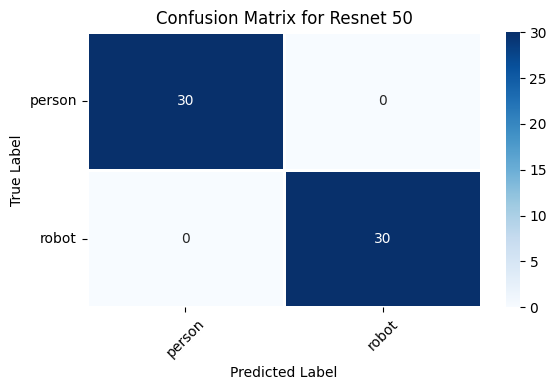

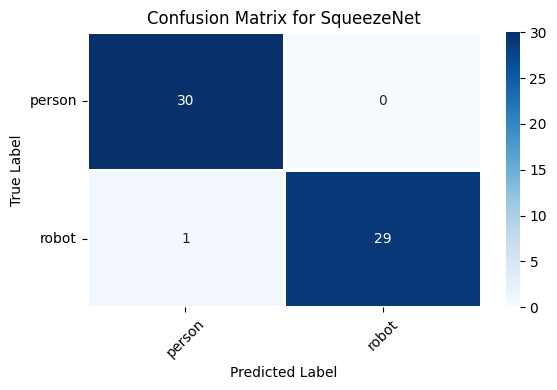

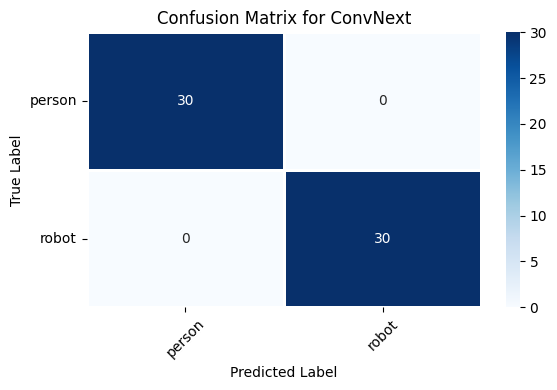

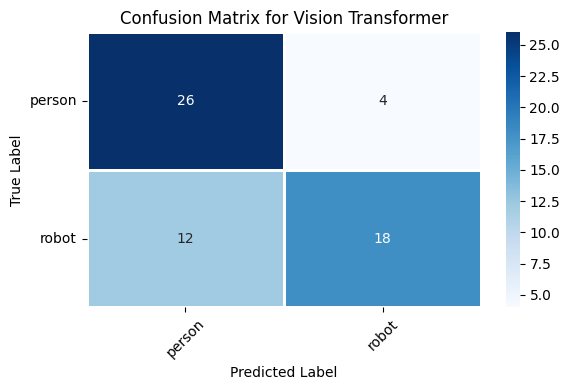

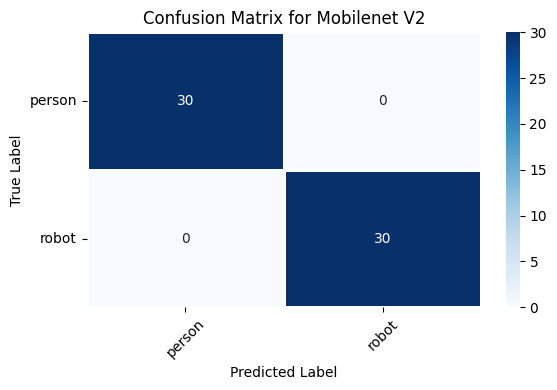

In [56]:
plot_confusion_matrix(y_true, resnet_predictions, label_names, 'Resnet 50')
plot_confusion_matrix(y_true, squeezenet_predictions, label_names, 'SqueezeNet')
plot_confusion_matrix(y_true, convnext_predictions, label_names, 'ConvNext')
plot_confusion_matrix(y_true, vit_predictions, label_names, 'Vision Transformer')
plot_confusion_matrix(y_true, mobilenet_predictions, label_names, 'Mobilenet V2')

In [61]:
def plot_performance(df):
    """
    Plot performance for the ResNet model.
    """
    train_losses = df['Train Loss'].values
    test_losses = df['Test Loss'].values
    train_accuracies = df['Train Accuracy'].values
    test_accuracies = df['Test Accuracy'].values

    
    plt.figure(figsize=(12, 5))
    
    # Plot Train Loss vs Test Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o', markeredgecolor='black')
    plt.plot(test_losses, label='Test Loss', marker='o', markeredgecolor='black')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')
    
    # Plot Train Accuracy vs Test Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o', markeredgecolor='black')
    plt.plot(test_accuracies, label='Test Accuracy', marker='o', markeredgecolor='black')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    
    plt.tight_layout()
    plt.show()

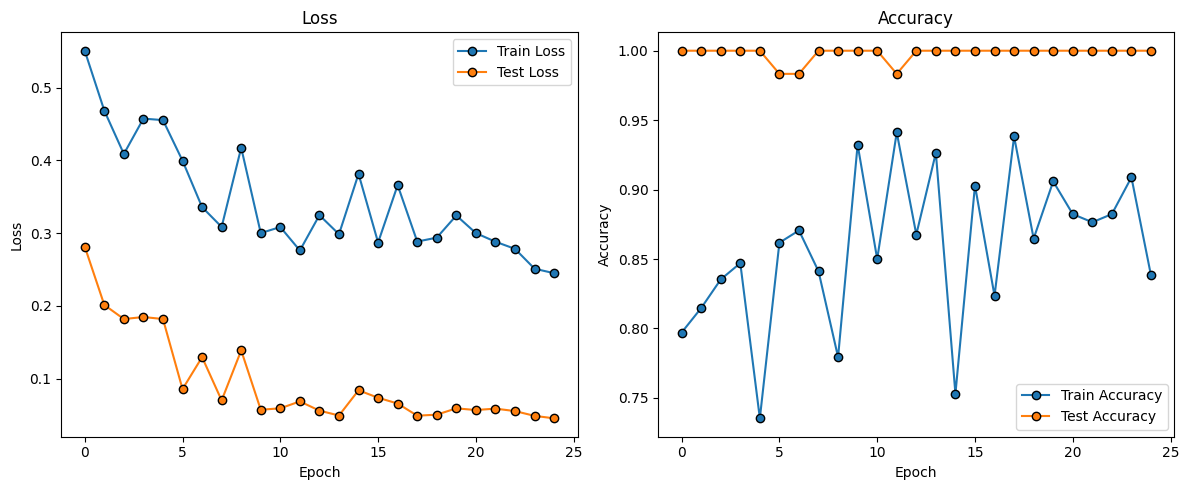

In [62]:
resnet_metrics = pd.read_csv("/home/ahmad/courses/cuda_lab/MA-INF-4308-Lab-Vision-Systems/Assignment-3/models/resnet_training_results.csv")
plot_performance(resnet_metrics)